In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import regex as rg

In [2]:
path = os.path.join("House")
def load_csv(path,filename):
    return pd.read_csv(os.path.join(filename))


In [3]:
train_data = load_csv(path,"train.csv")
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
def relative_attribute_sale(attribute,train_data):
    return pd.DataFrame(train_data.groupby(by= attribute)['SalePrice'].mean().reset_index().sort_values(by = "SalePrice",ascending = True))

## Missing percent

In [9]:
na_list = set([i if len(set(train_data[i].isna())) == 2 else 0 for i in list(train_data)])
na_list.remove(0)
print(na_list)

{'BsmtFinType2', 'Fence', 'PoolQC', 'FireplaceQu', 'GarageType', 'GarageQual', 'Alley', 'GarageCond', 'MiscFeature', 'Electrical', 'MasVnrType', 'MasVnrArea', 'BsmtFinType1', 'LotFrontage', 'GarageYrBlt', 'GarageFinish', 'BsmtCond', 'BsmtQual', 'BsmtExposure'}


Garage,Fence,Bsmt,alley,MasVnr,Misc,

In [11]:
percent_nan = {}
for attribute in na_list:
    percent_nan[attribute] = (train_data[attribute].isna().sum() / train_data[attribute].shape[0])*100
print(percent_nan)

{'BsmtFinType2': 2.6027397260273974, 'Fence': 80.75342465753424, 'PoolQC': 99.52054794520548, 'FireplaceQu': 47.26027397260274, 'GarageType': 5.5479452054794525, 'GarageQual': 5.5479452054794525, 'Alley': 93.76712328767123, 'GarageCond': 5.5479452054794525, 'MiscFeature': 96.30136986301369, 'Electrical': 0.0684931506849315, 'MasVnrType': 0.547945205479452, 'MasVnrArea': 0.547945205479452, 'BsmtFinType1': 2.5342465753424657, 'LotFrontage': 17.73972602739726, 'GarageYrBlt': 5.5479452054794525, 'GarageFinish': 5.5479452054794525, 'BsmtCond': 2.5342465753424657, 'BsmtQual': 2.5342465753424657, 'BsmtExposure': 2.6027397260273974}


In [12]:
garage_percent = percent_nan['GarageCond']
temp_percent_nan = percent_nan.copy()
for key,value in temp_percent_nan.items():
    if rg.findall("Garage",key):
        percent_nan.pop(key)
percent_nan['Garage'] = garage_percent

In [13]:
percent_nan

{'BsmtFinType2': 2.6027397260273974,
 'Fence': 80.75342465753424,
 'PoolQC': 99.52054794520548,
 'FireplaceQu': 47.26027397260274,
 'Alley': 93.76712328767123,
 'MiscFeature': 96.30136986301369,
 'Electrical': 0.0684931506849315,
 'MasVnrType': 0.547945205479452,
 'MasVnrArea': 0.547945205479452,
 'BsmtFinType1': 2.5342465753424657,
 'LotFrontage': 17.73972602739726,
 'BsmtCond': 2.5342465753424657,
 'BsmtQual': 2.5342465753424657,
 'BsmtExposure': 2.6027397260273974,
 'Garage': 5.5479452054794525}

In [14]:
percent_nan = pd.DataFrame.from_dict(percent_nan,orient='index').reset_index().rename({'index':'Name',0:'Missing Percent'},axis=1)


In [15]:
percent_nan.sort_values(by = 'Missing Percent',inplace=True)

In [16]:
percent_nan

,Name,Missing Percent
6,Electrical,0.068493
7,MasVnrType,0.547945
8,MasVnrArea,0.547945
9,BsmtFinType1,2.534247
11,BsmtCond,2.534247
12,BsmtQual,2.534247
0,BsmtFinType2,2.602740
13,BsmtExposure,2.602740
14,Garage,5.547945
10,LotFrontage,17.739726


<AxesSubplot:title={'center':'Missing percent'}, xlabel='Name', ylabel='Missing Percent'>

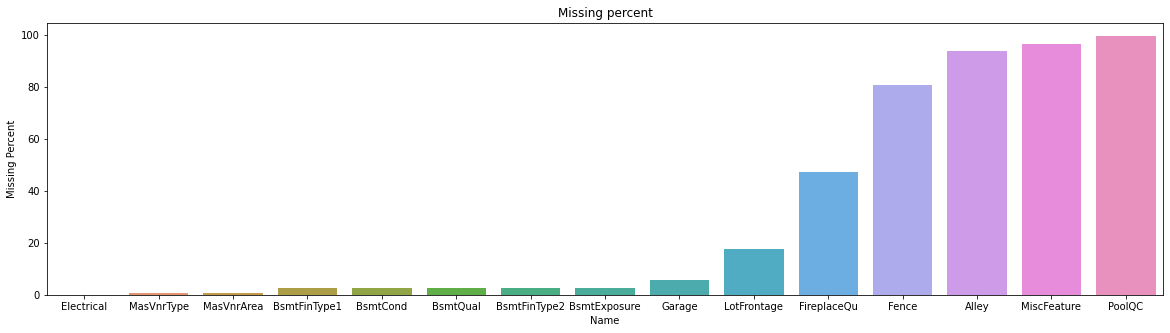

In [17]:
plt.figure(figsize = (20,5))
plt.title("Missing percent")
sns.barplot(data = percent_nan,x='Name',y= 'Missing Percent',order = percent_nan['Name'])

* Cate: MSSubClass, MSZoning, Street, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, RoofStyle, RoofMatl
* Number: 

In [18]:
def ScaleNotChangePrice(attribute,point_attribute,train_data= train_data):
    mean_price = train_data[train_data[attribute] == point_attribute]["SalePrice"].mean()
    interval = [mean_price-30000,mean_price+30000]
    return train_data[(train_data['SalePrice'] > interval[0]) & (train_data['SalePrice'] < interval[1])][attribute].mean()

### MSSUBCLASS


In [19]:
train_data['MSSubClass'].value_counts().index

Int64Index([20, 60, 50, 120, 30, 160, 70, 80, 90, 190, 85, 75, 45, 180, 40], dtype='int64')

In [20]:
train_data['MSSubClass'].value_counts(ascending=True).index

Int64Index([40, 180, 45, 75, 85, 190, 90, 80, 70, 160, 30, 120, 50, 60, 20], dtype='int64')

In [21]:
train_data['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [22]:
train_data.groupby(by = 'MSSubClass')['SalePrice'].mean().sort_values(ascending = True).index

Int64Index([30, 180, 45, 190, 90, 160, 50, 85, 40, 70, 80, 20, 75, 120, 60], dtype='int64', name='MSSubClass')

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

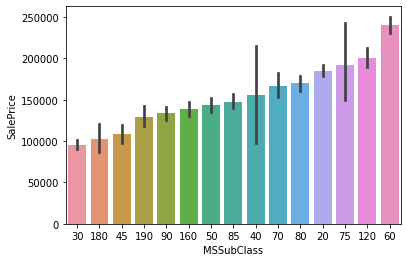

In [23]:
sns.barplot(data = train_data,x='MSSubClass',y='SalePrice',order = train_data.groupby(by = 'MSSubClass')['SalePrice'].mean().sort_values(ascending = True).index)

## MSZoning


In [24]:
train_data.groupby('MSZoning').mean().sort_values(by='SalePrice')['SalePrice']

MSZoning
C (all)     74528.000000
RM         126316.830275
RH         131558.375000
RL         191004.994787
FV         214014.061538
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='MSZoning', ylabel='SalePrice'>

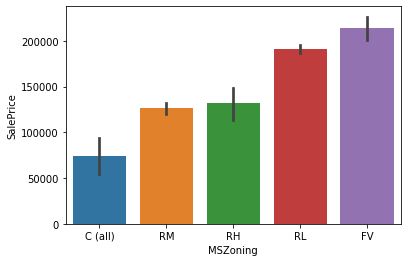

In [25]:
sns.barplot(data = train_data,x = 'MSZoning',y = 'SalePrice',order = train_data.groupby('MSZoning').mean().sort_values(by='SalePrice')['SalePrice'].index)

RM, RH same? 

## LotFrontage: has NAN

<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

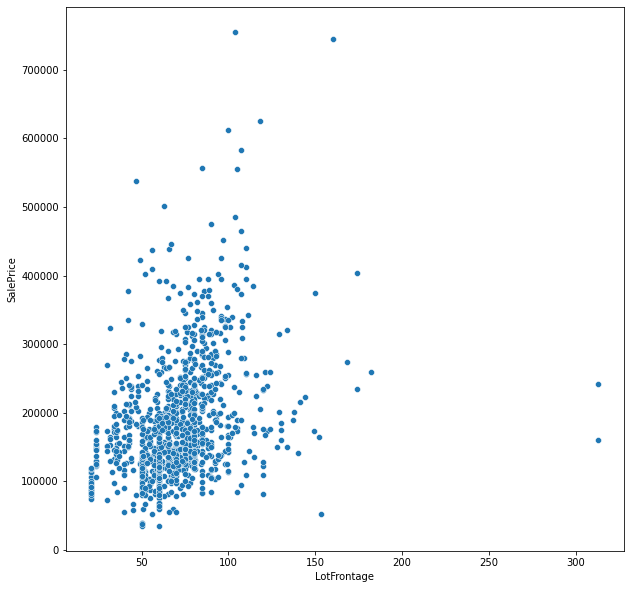

In [26]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x = 'LotFrontage',y= 'SalePrice')

In [27]:
train_data['LotFrontage'] = train_data['LotFrontage'].apply(lambda x: ScaleNotChangePrice("LotFrontage",x) if x > 250 else x)

<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

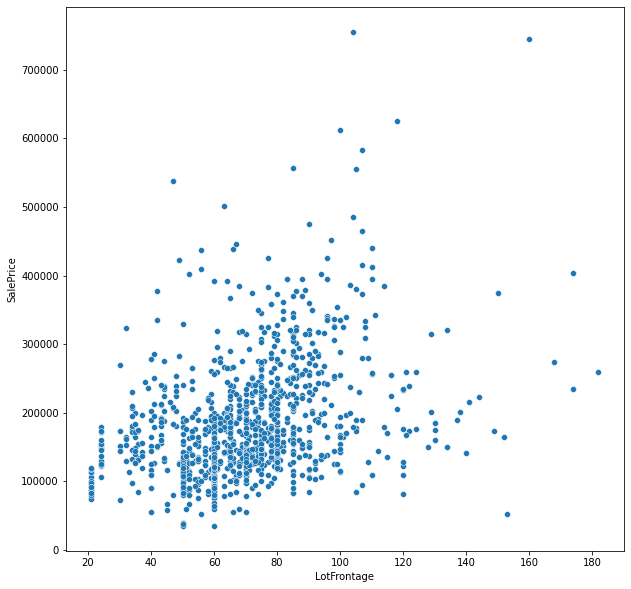

In [28]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x = 'LotFrontage',y= 'SalePrice')

Sale > 700000?

## Lot Area

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

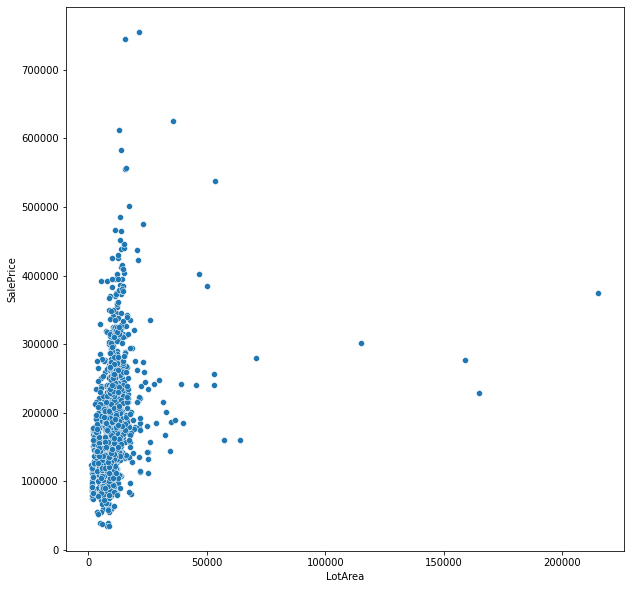

In [29]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x = 'LotArea',y='SalePrice')

In [30]:
train_data['LotArea'] = train_data['LotArea'].apply(lambda x: ScaleNotChangePrice("LotArea",x) if x > 100000 else x) 

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

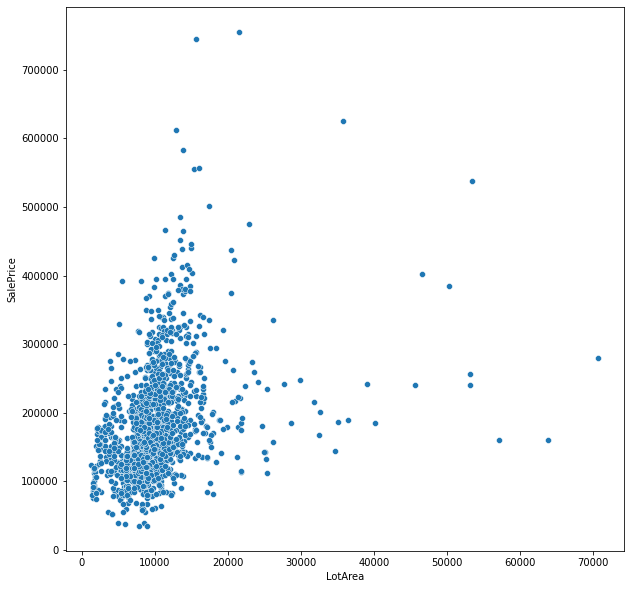

In [31]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x = 'LotArea',y='SalePrice')

## Street

In [32]:
train_data['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

<AxesSubplot:xlabel='Street', ylabel='SalePrice'>

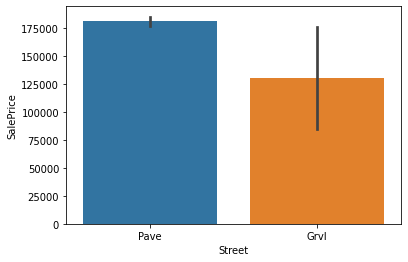

In [33]:
sns.barplot(data = train_data, x = 'Street',y='SalePrice')

## Alley: has NAN

In [34]:
train_data['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [35]:
len(train_data['Alley'].isna())

1460

In [36]:
train_data['Alley'] = train_data['Alley'].fillna(0)


<AxesSubplot:xlabel='Alley', ylabel='SalePrice'>

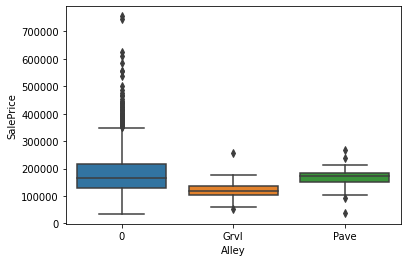

In [37]:
sns.boxplot(data = train_data,x = 'Alley',y='SalePrice')

## LotShape

In [38]:
train_data['LotShape'].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

<AxesSubplot:xlabel='LotShape', ylabel='SalePrice'>

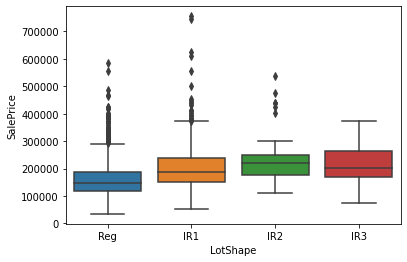

In [39]:
sns.boxplot(data = train_data,x = 'LotShape',y='SalePrice')

## LandContour

<AxesSubplot:xlabel='LandContour', ylabel='SalePrice'>

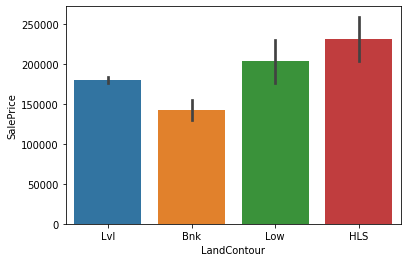

In [40]:
sns.barplot(data = train_data,x = 'LandContour',y='SalePrice')

## Utilities

<AxesSubplot:xlabel='Utilities', ylabel='SalePrice'>

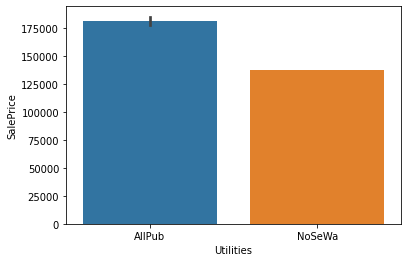

In [41]:
sns.barplot(data = train_data,x = 'Utilities',y='SalePrice')

## LotConfig

<AxesSubplot:xlabel='LotConfig', ylabel='SalePrice'>

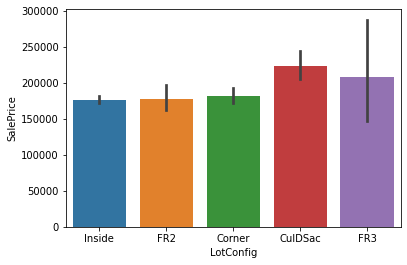

In [42]:
sns.barplot(data = train_data,x='LotConfig',y='SalePrice')

## LandSlope

<AxesSubplot:xlabel='LandSlope', ylabel='SalePrice'>

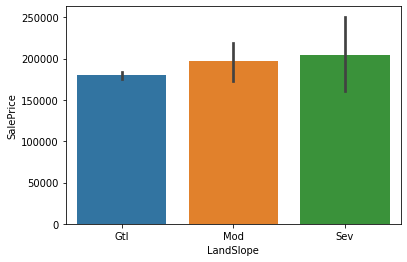

In [43]:
sns.barplot(data = train_data,x='LandSlope',y='SalePrice')

## Neighborhood

In [44]:
train_data['Neighborhood'].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

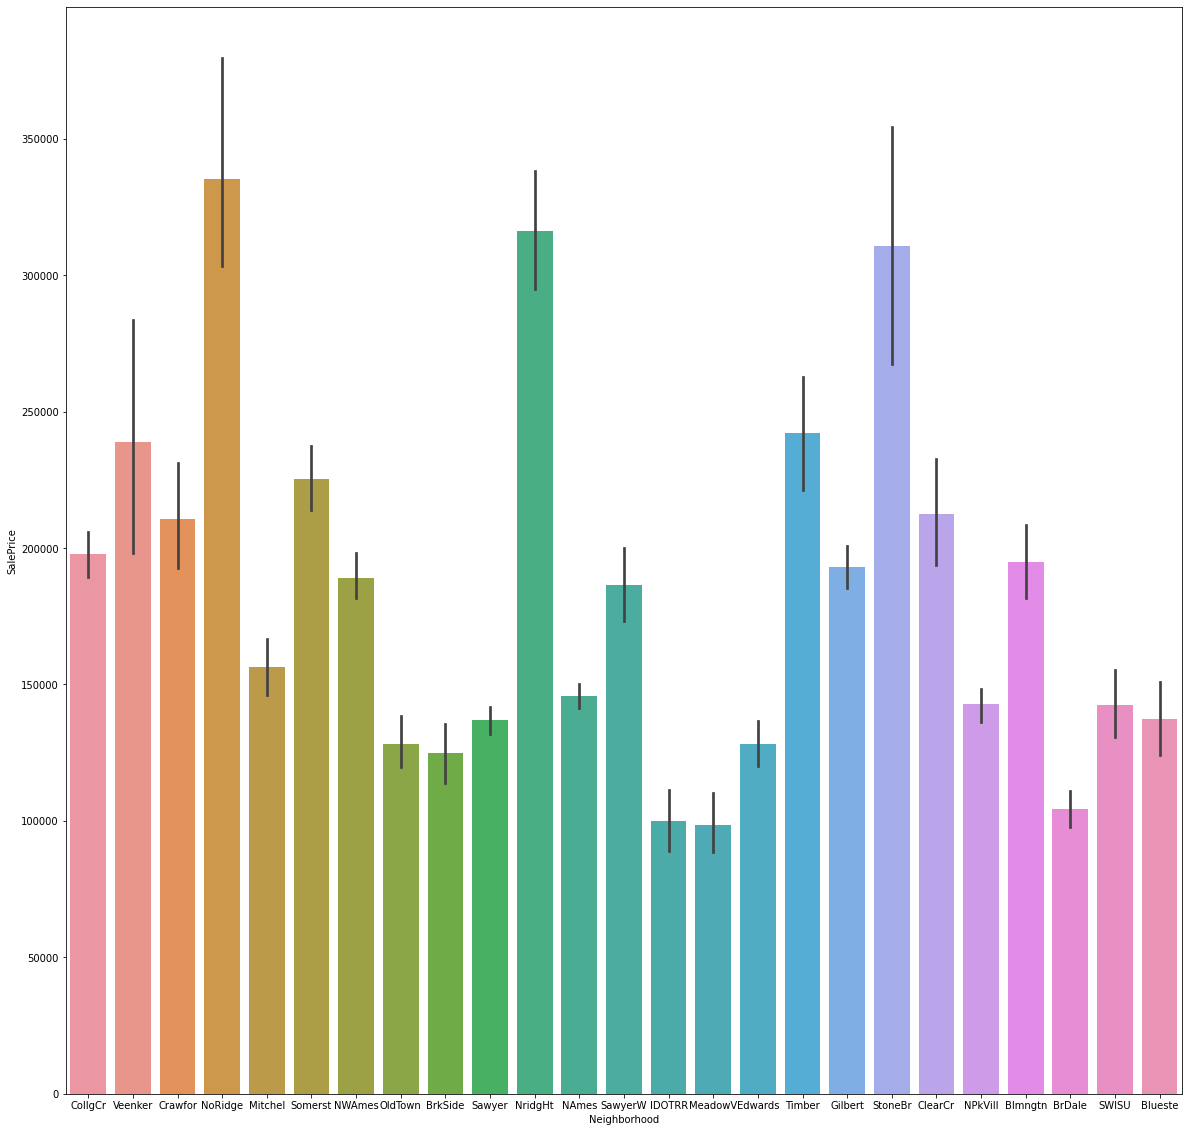

In [45]:
plt.figure(figsize = (20,20))
sns.barplot(data = train_data,x='Neighborhood',y='SalePrice')

group ?

## Condition1 + Condition2

<AxesSubplot:xlabel='Condition1', ylabel='SalePrice'>

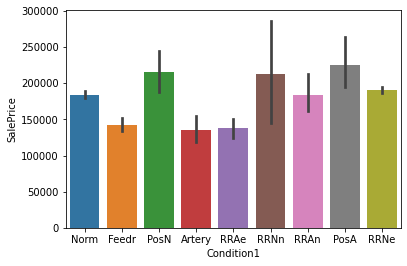

In [46]:
sns.barplot(data = train_data,x = 'Condition1',y='SalePrice')

<AxesSubplot:xlabel='Condition2', ylabel='SalePrice'>

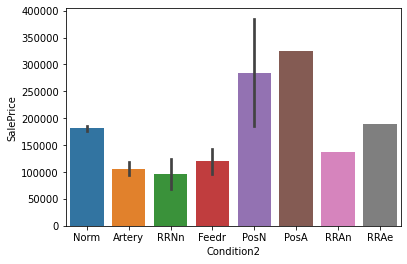

In [47]:
sns.barplot(data = train_data,x = 'Condition2',y='SalePrice')

## BldgType

<AxesSubplot:xlabel='BldgType', ylabel='SalePrice'>

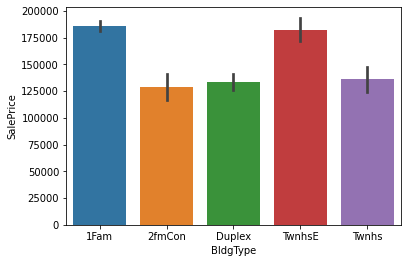

In [48]:
sns.barplot(data = train_data,x='BldgType',y = 'SalePrice')

## HouseStyle

<AxesSubplot:xlabel='HouseStyle', ylabel='SalePrice'>

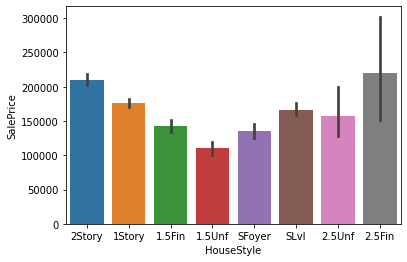

In [49]:
sns.barplot(data = train_data,x='HouseStyle',y = 'SalePrice')

## OverallQual + OverallCond

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

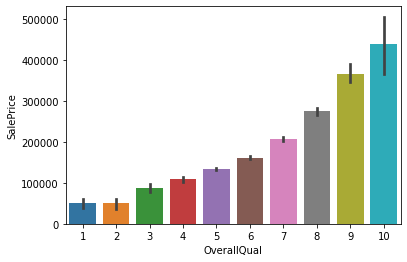

In [50]:
sns.barplot(data = train_data,x='OverallQual',y = 'SalePrice')

<AxesSubplot:xlabel='OverallCond', ylabel='SalePrice'>

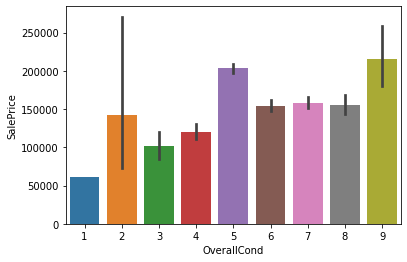

In [51]:
sns.barplot(data = train_data,x='OverallCond',y = 'SalePrice')

why 5 and 2 ? 

## Year Built 

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

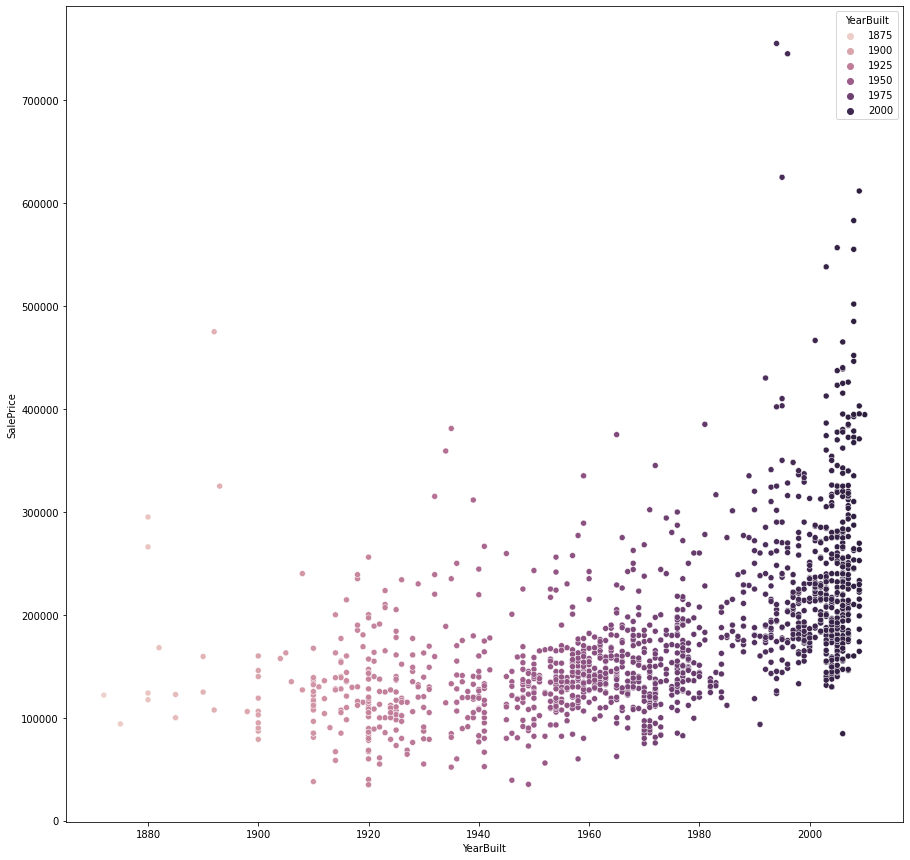

In [52]:
plt.figure(figsize = (15,15))
sns.scatterplot(data = train_data,x='YearBuilt',y='SalePrice',hue = 'YearBuilt')

higher year => higher price

## YearRemodAdd

<AxesSubplot:xlabel='YearRemodAdd', ylabel='SalePrice'>

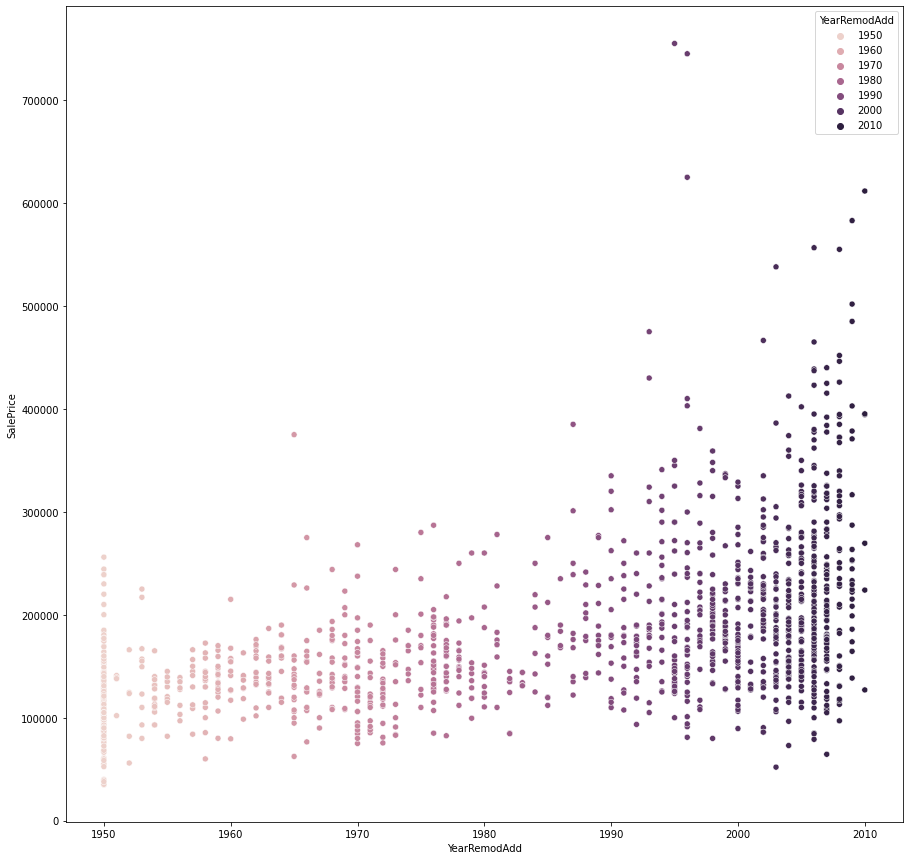

In [53]:
plt.figure(figsize = (15,15))
sns.scatterplot(data = train_data,x='YearRemodAdd',y='SalePrice',hue = 'YearRemodAdd')

same as YearBuilt

## RoofStyle

In [54]:
train_data['RoofStyle'].value_counts()

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

<AxesSubplot:xlabel='RoofStyle', ylabel='SalePrice'>

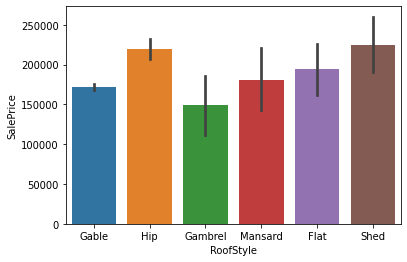

In [55]:
sns.barplot(data = train_data,x='RoofStyle',y='SalePrice')

## RoofMatl

<AxesSubplot:xlabel='RoofMatl', ylabel='SalePrice'>

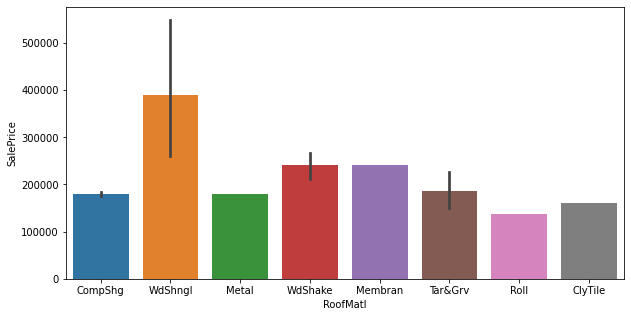

In [56]:
plt.figure(figsize = (10,5))
sns.barplot(data = train_data,x='RoofMatl',y='SalePrice')

## Exterior1st + 2nd

<AxesSubplot:xlabel='Exterior1st', ylabel='SalePrice'>

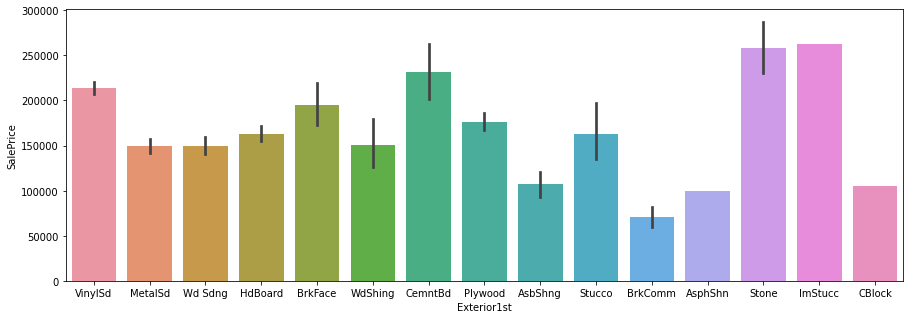

In [57]:
plt.figure(figsize = (15,5))
sns.barplot(data = train_data,x='Exterior1st',y='SalePrice')

<AxesSubplot:xlabel='Exterior2nd', ylabel='SalePrice'>

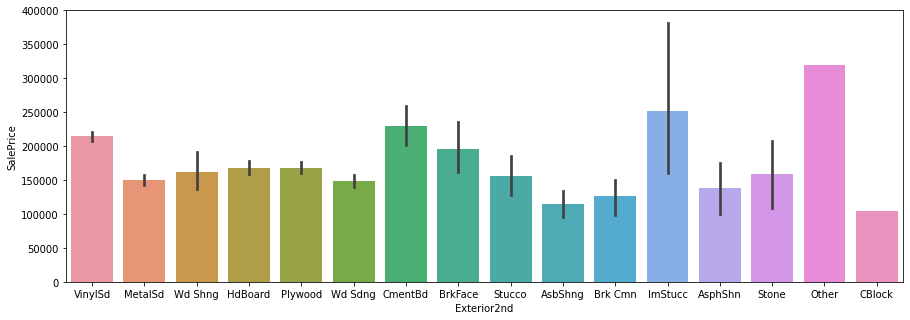

In [58]:
plt.figure(figsize = (15,5))
sns.barplot(data = train_data,x='Exterior2nd',y='SalePrice')

## MasVnrType: has NAN

In [59]:
train_data['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [60]:
train_data['MasVnrType'] = train_data['MasVnrType'].fillna(0)

fill CBlock?

<AxesSubplot:xlabel='MasVnrType', ylabel='SalePrice'>

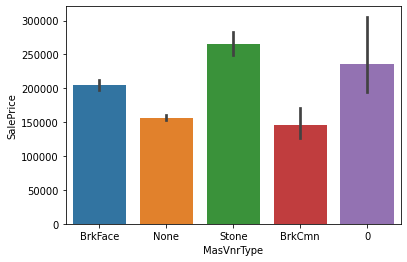

In [61]:
sns.barplot(data = train_data,x='MasVnrType',y='SalePrice')

## MasVnrArea: has NAN

<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice'>

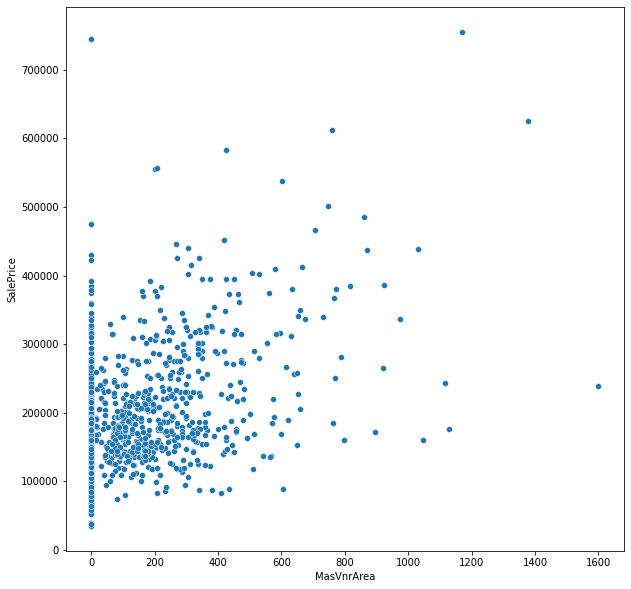

In [62]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='MasVnrArea',y='SalePrice')

In [63]:
train_data['MasVnrArea'] = train_data['MasVnrArea'].apply(lambda x: ScaleNotChangePrice("MasVnrArea",x) if x > 1350 else x)

<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice'>

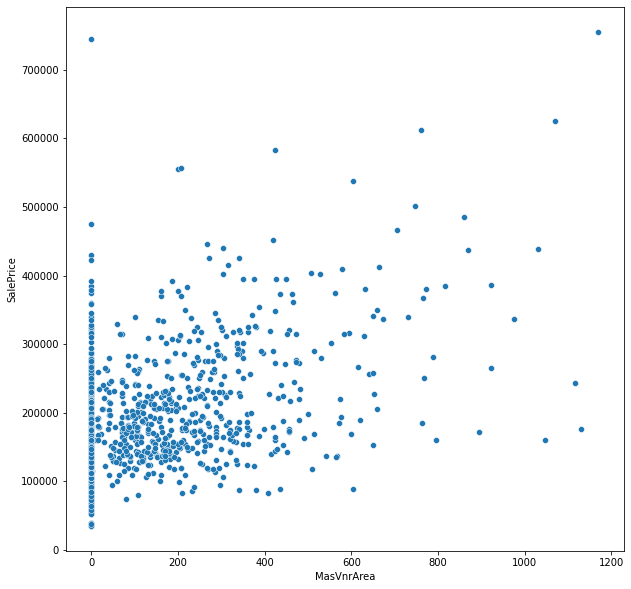

In [64]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='MasVnrArea',y='SalePrice')

## ExterQual + ExterCond

<AxesSubplot:xlabel='ExterQual', ylabel='SalePrice'>

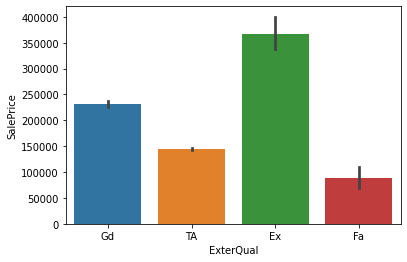

In [65]:
sns.barplot(data = train_data,x='ExterQual',y='SalePrice')

<AxesSubplot:xlabel='ExterCond', ylabel='SalePrice'>

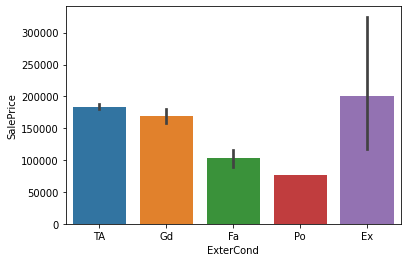

In [66]:
sns.barplot(data = train_data,x='ExterCond',y='SalePrice')

## Foundation

<AxesSubplot:xlabel='Foundation', ylabel='SalePrice'>

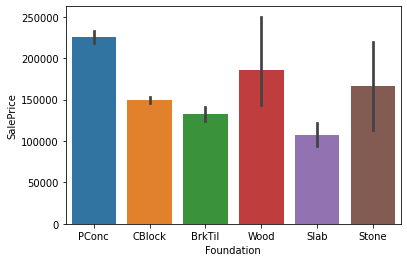

In [67]:
sns.barplot(data = train_data,x='Foundation',y='SalePrice')

## Basement: has NAN

### BsmtQual 

In [68]:
train_data['BsmtQual'].value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [69]:
train_data['BsmtQual'] = train_data['BsmtQual'].fillna(0)

<AxesSubplot:xlabel='BsmtQual', ylabel='SalePrice'>

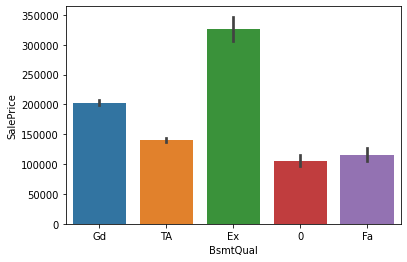

In [70]:
sns.barplot(data = train_data,x='BsmtQual',y='SalePrice')

### BsmtCond

In [71]:
train_data['BsmtCond'].value_counts()

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [72]:
train_data['BsmtCond'] = train_data['BsmtCond'].fillna(0)

<AxesSubplot:xlabel='BsmtCond', ylabel='SalePrice'>

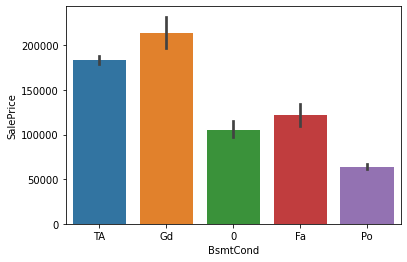

In [73]:
sns.barplot(data = train_data,x='BsmtCond',y='SalePrice')

### BsmtExposure

In [74]:
train_data['BsmtExposure'].value_counts()

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [75]:
train_data['BsmtExposure'] = train_data['BsmtExposure'].fillna(0)

<AxesSubplot:xlabel='BsmtExposure', ylabel='SalePrice'>

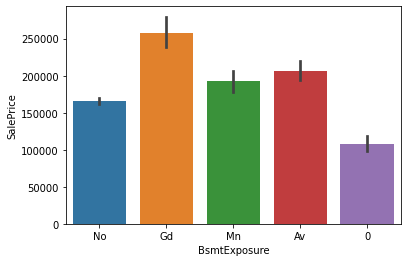

In [76]:
sns.barplot(data = train_data,x='BsmtExposure',y='SalePrice')

### BsmtFinType1

In [77]:
train_data['BsmtFinType1'].value_counts()

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [78]:
train_data['BsmtFinType1'] = train_data['BsmtFinType1'].fillna(0)

<AxesSubplot:xlabel='BsmtFinType1', ylabel='SalePrice'>

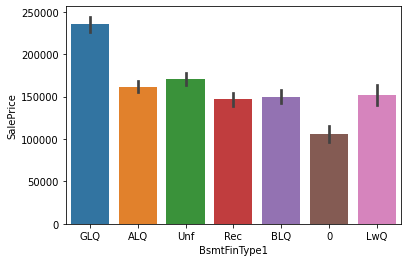

In [79]:
sns.barplot(data = train_data,x='BsmtFinType1',y='SalePrice')

### BsmtFinSF1

<AxesSubplot:xlabel='BsmtFinSF1', ylabel='SalePrice'>

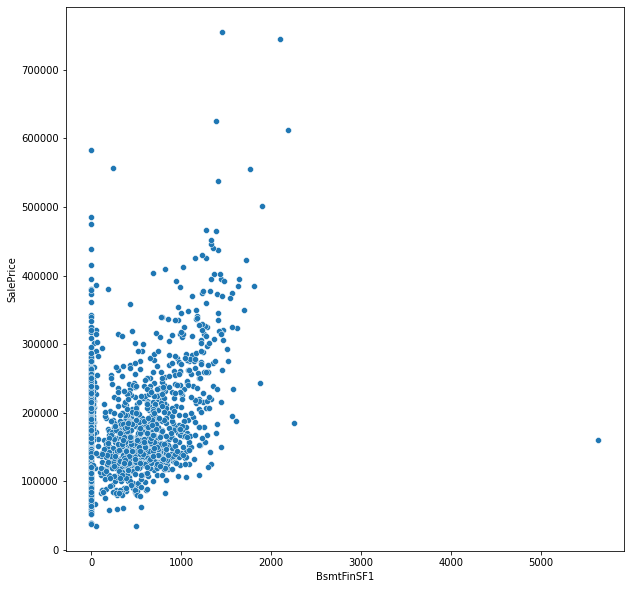

In [80]:
plt.figure(figsize = (10,10))
sns.scatterplot(data=train_data,x='BsmtFinSF1',y='SalePrice')

In [81]:
train_data["BsmtFinSF1"] = train_data["BsmtFinSF1"].apply(lambda x: ScaleNotChangePrice("BsmtFinSF1",x) if x > 4000 else x)

<AxesSubplot:xlabel='BsmtFinSF1', ylabel='SalePrice'>

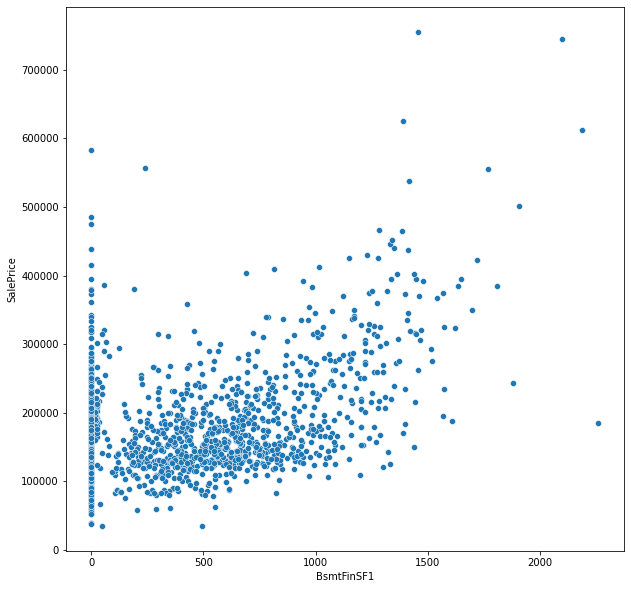

In [82]:
plt.figure(figsize = (10,10))
sns.scatterplot(data=train_data,x='BsmtFinSF1',y='SalePrice')

### BsmtFinType2

In [83]:
train_data['BsmtFinType2'].value_counts()

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [84]:
train_data['BsmtFinType2'] = train_data['BsmtFinType2'].fillna(0)

<AxesSubplot:xlabel='BsmtFinType2', ylabel='SalePrice'>

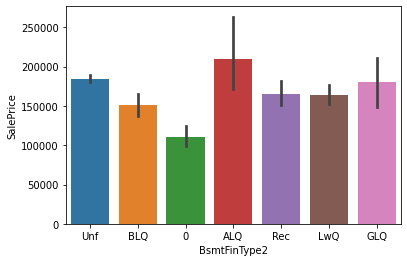

In [85]:
sns.barplot(data = train_data,x='BsmtFinType2',y='SalePrice')

### BsmtFinSF2

<AxesSubplot:xlabel='BsmtFinSF2', ylabel='SalePrice'>

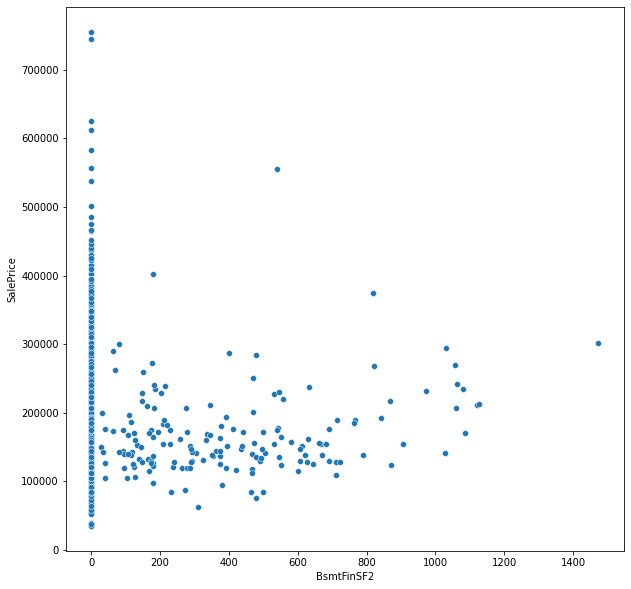

In [86]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='BsmtFinSF2',y = 'SalePrice')

In [87]:
train_data['BsmtFinSF2'] = train_data['BsmtFinSF2'].apply(lambda x: ScaleNotChangePrice("BsmtFinSF2",x) if x> 1300 else x)

<AxesSubplot:xlabel='BsmtFinSF2', ylabel='SalePrice'>

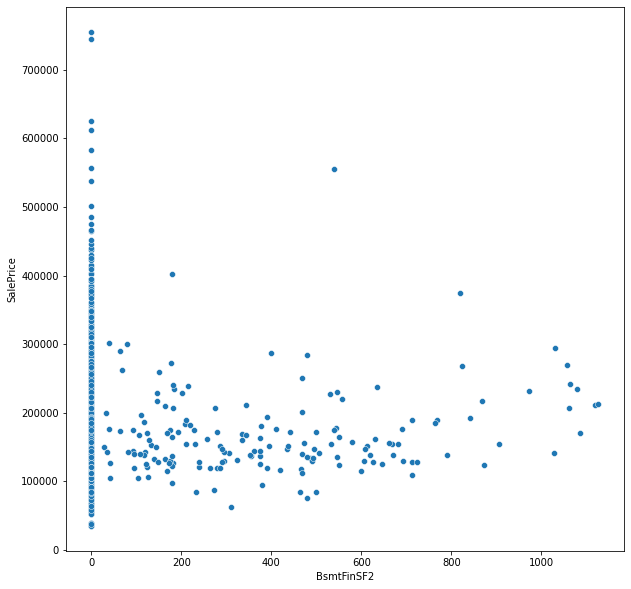

In [88]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='BsmtFinSF2',y = 'SalePrice')

### BsmtUnfSF

<AxesSubplot:xlabel='BsmtUnfSF', ylabel='SalePrice'>

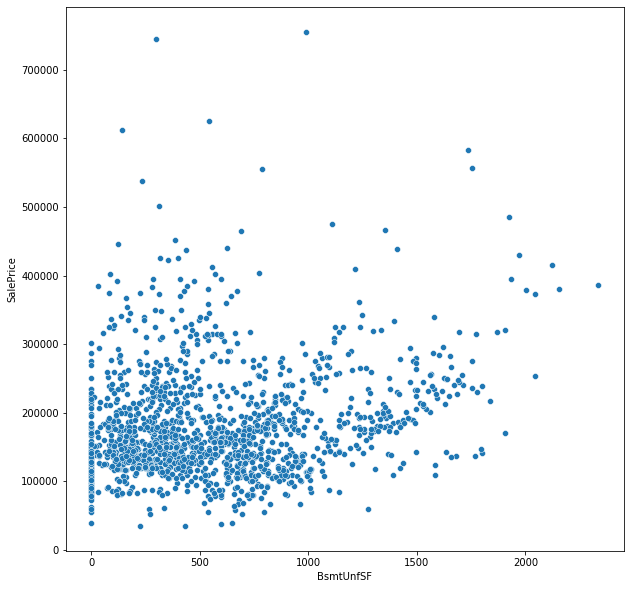

In [89]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='BsmtUnfSF',y='SalePrice')

how ??? 

### TotalBsmtSF

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

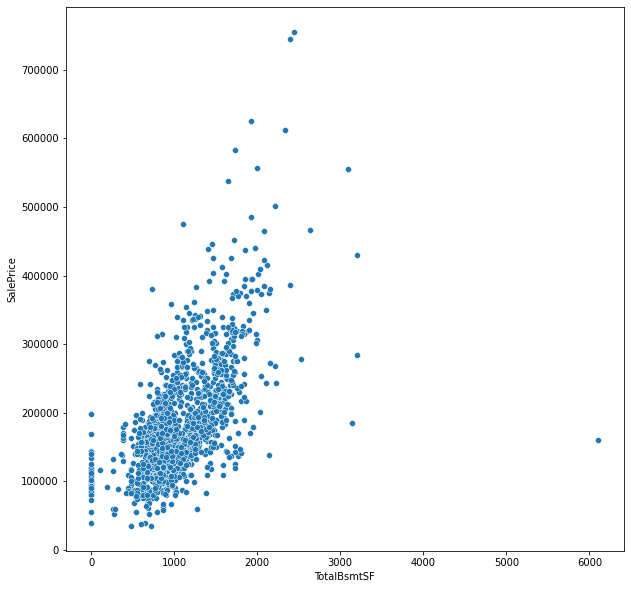

In [90]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='TotalBsmtSF',y='SalePrice')

In [91]:
train_data['TotalBsmtSF'] = train_data['TotalBsmtSF'].apply(lambda x: ScaleNotChangePrice('TotalBsmtSF',x) if x> 5500 else x)

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

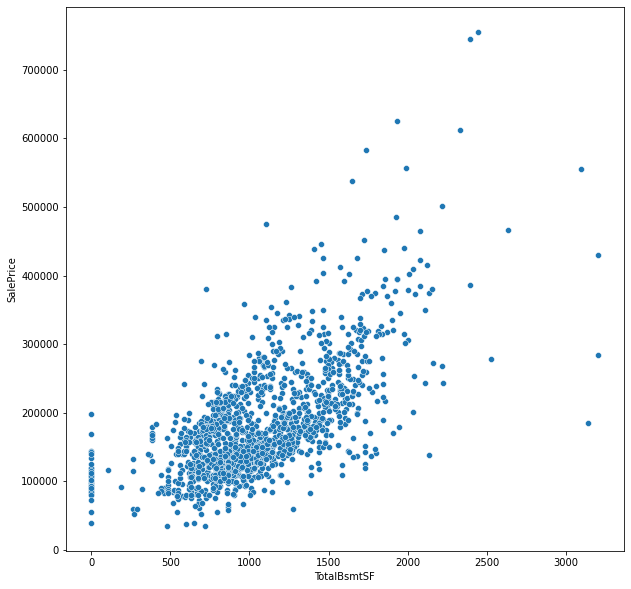

In [92]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='TotalBsmtSF',y='SalePrice')

## Heating

### Heating

<AxesSubplot:xlabel='Heating', ylabel='SalePrice'>

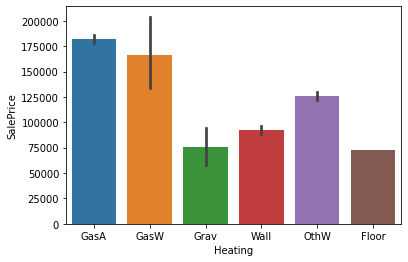

In [93]:
sns.barplot(data = train_data,x='Heating',y='SalePrice')

### HeatingQC

<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice'>

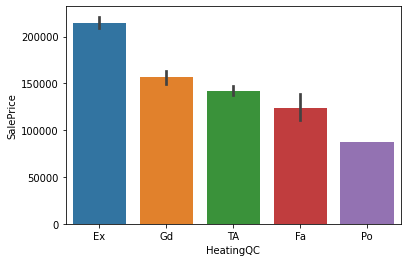

In [94]:
sns.barplot(data = train_data,x='HeatingQC',y='SalePrice')

## CentralAir

<AxesSubplot:xlabel='CentralAir', ylabel='SalePrice'>

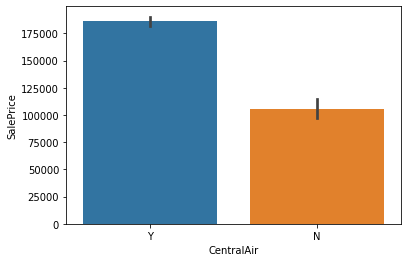

In [95]:
sns.barplot(data = train_data,x='CentralAir',y='SalePrice')

## Electrical

<AxesSubplot:xlabel='Electrical', ylabel='SalePrice'>

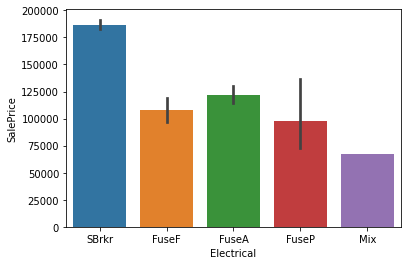

In [96]:
sns.barplot(data = train_data,x='Electrical',y='SalePrice')

## 1stFlrSF

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

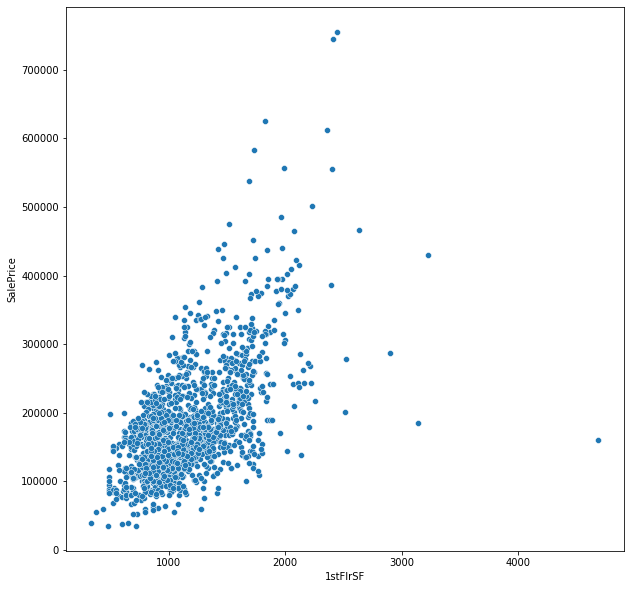

In [97]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='1stFlrSF',y='SalePrice')

In [98]:
train_data['1stFlrSF'] = train_data['1stFlrSF'].apply(lambda x:ScaleNotChangePrice('1stFlrSF',x) if x> 4000 else x)

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

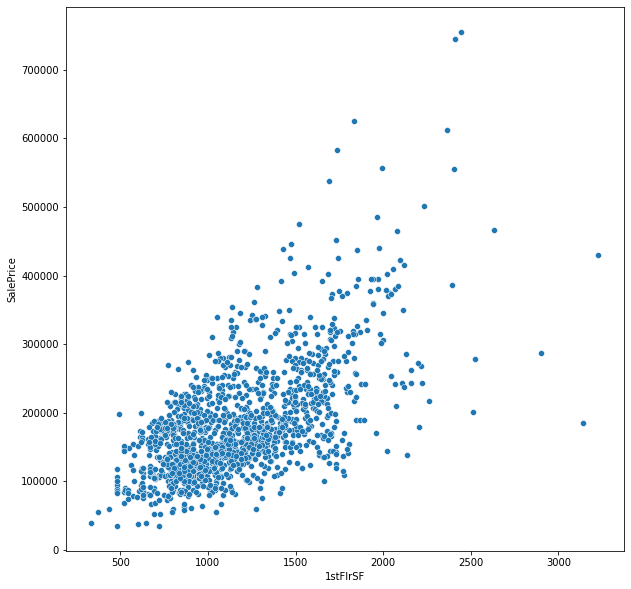

In [99]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='1stFlrSF',y='SalePrice')

## 2ndFlrSF

<AxesSubplot:xlabel='2ndFlrSF', ylabel='SalePrice'>

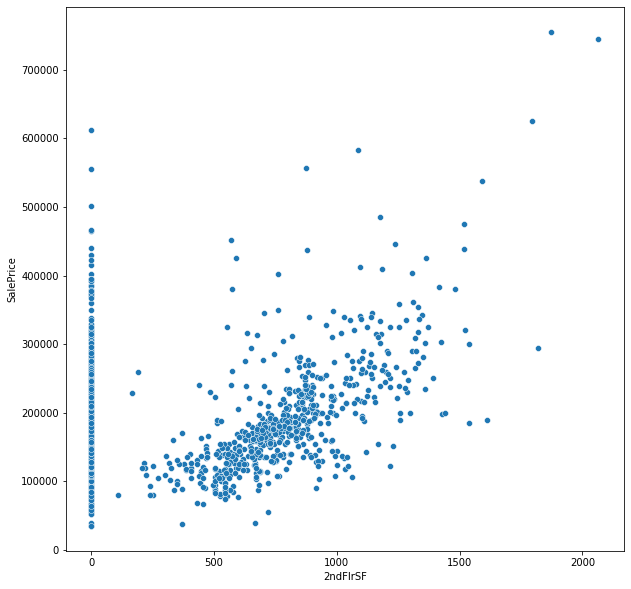

In [100]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='2ndFlrSF',y='SalePrice')

## LowQualFinSF

<AxesSubplot:xlabel='LowQualFinSF', ylabel='SalePrice'>

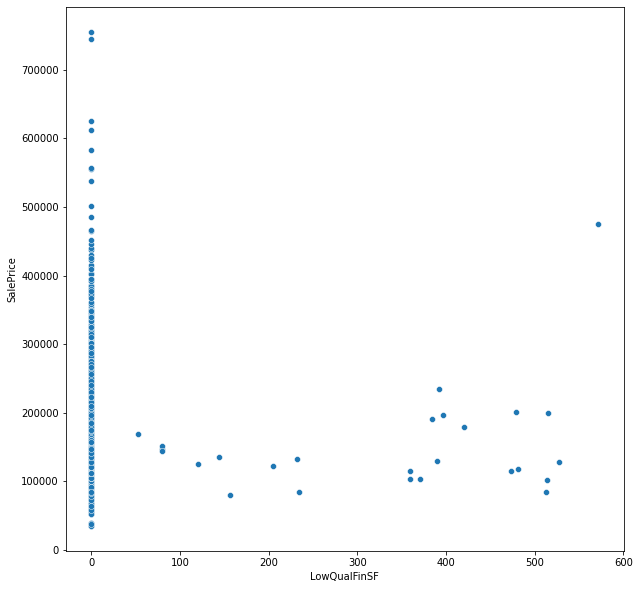

In [101]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='LowQualFinSF',y='SalePrice')

## GrLivArea

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

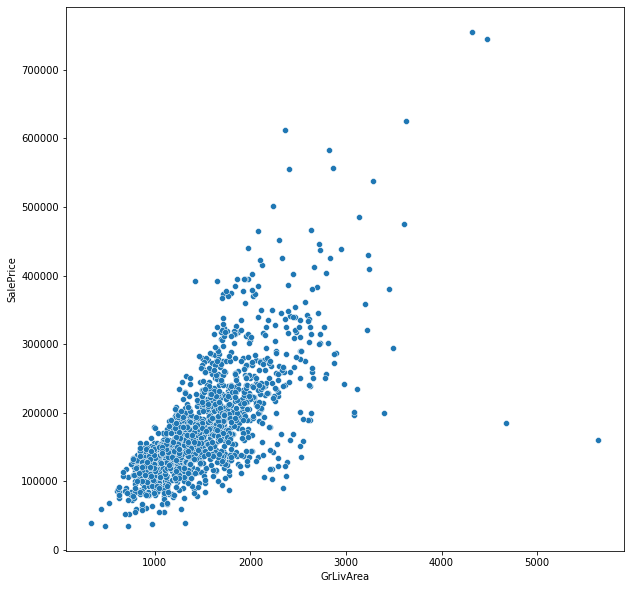

In [102]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='GrLivArea',y='SalePrice')

In [103]:
train_data['GrLivArea'] = train_data['GrLivArea'].apply(lambda x: ScaleNotChangePrice('GrLivArea',x) if x > 4500 else x)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

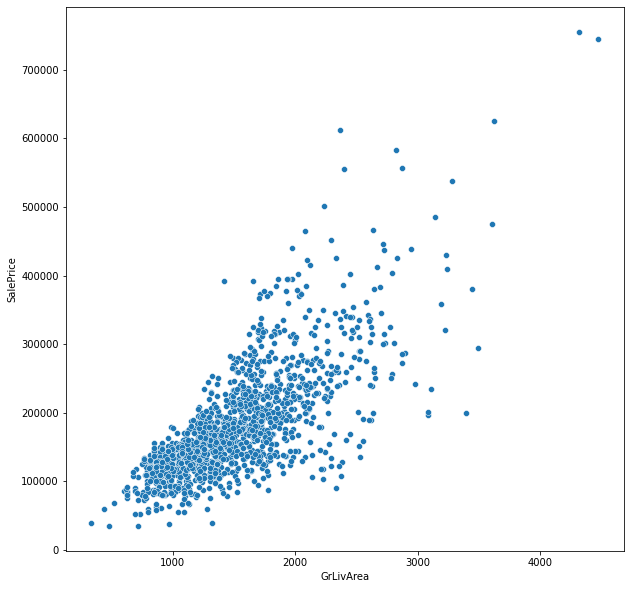

In [104]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='GrLivArea',y='SalePrice')

## Bathroom

### BsmtFullBath

In [105]:
train_data['BsmtFullBath'].value_counts()

0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

<AxesSubplot:xlabel='BsmtFullBath', ylabel='SalePrice'>

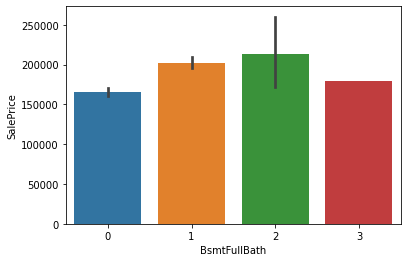

In [106]:
sns.barplot(data = train_data,x='BsmtFullBath',y='SalePrice')

2,3 ??

### BsmtHalfBath

In [107]:
train_data['BsmtHalfBath'].value_counts()

0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

<AxesSubplot:xlabel='BsmtHalfBath', ylabel='SalePrice'>

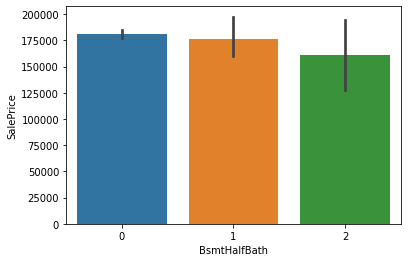

In [108]:
sns.barplot(data = train_data,x='BsmtHalfBath',y='SalePrice')

### FullBath

In [109]:
train_data['FullBath'].value_counts()

2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64

<AxesSubplot:xlabel='FullBath', ylabel='SalePrice'>

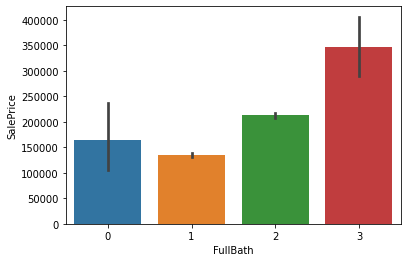

In [110]:
sns.barplot(data = train_data,x='FullBath',y='SalePrice')

### HalfBath

<AxesSubplot:xlabel='HalfBath', ylabel='SalePrice'>

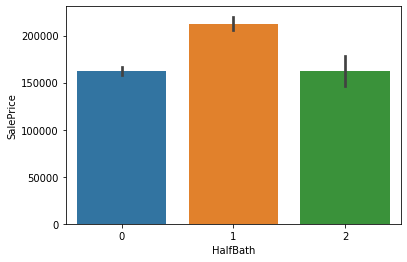

In [111]:
sns.barplot(data = train_data,x='HalfBath',y='SalePrice')

## BedroomAbvGr

<AxesSubplot:xlabel='BedroomAbvGr', ylabel='SalePrice'>

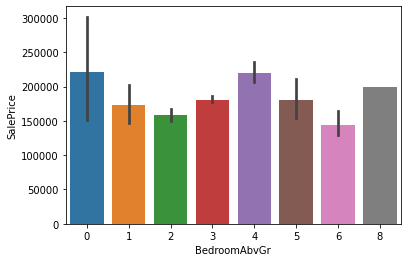

In [112]:
sns.barplot(data = train_data,x='BedroomAbvGr',y='SalePrice')

## Kitchen

### KitchenAbvGr

<AxesSubplot:xlabel='KitchenAbvGr', ylabel='SalePrice'>

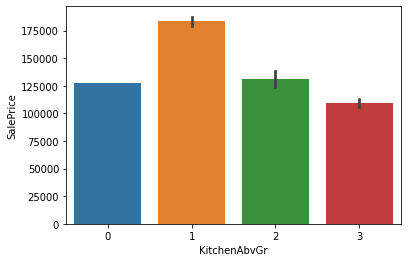

In [113]:
sns.barplot(data = train_data,x='KitchenAbvGr',y='SalePrice')

### KitchenQual

<AxesSubplot:xlabel='KitchenQual', ylabel='SalePrice'>

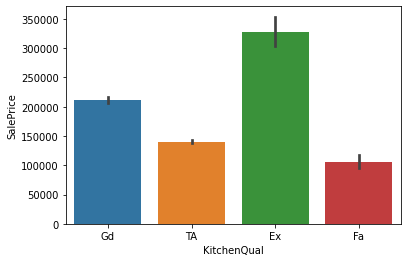

In [114]:
sns.barplot(data = train_data,x='KitchenQual',y='SalePrice')

## TotRmsAbvGrd (does not include bathrooms)

<AxesSubplot:xlabel='TotRmsAbvGrd', ylabel='SalePrice'>

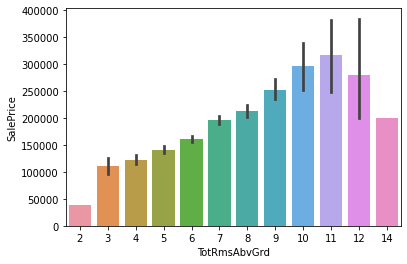

In [115]:
sns.barplot(data = train_data,x='TotRmsAbvGrd',y='SalePrice')

## Home functionality

<AxesSubplot:xlabel='Functional', ylabel='SalePrice'>

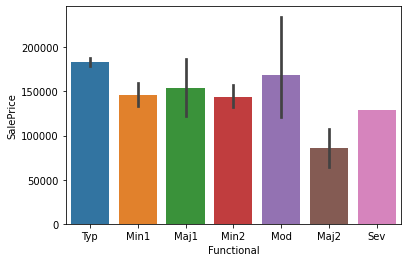

In [116]:
sns.barplot(data = train_data,x='Functional',y='SalePrice')

## FirePlace

### Fireplaces : Number of fireplaces

<AxesSubplot:xlabel='Fireplaces', ylabel='SalePrice'>

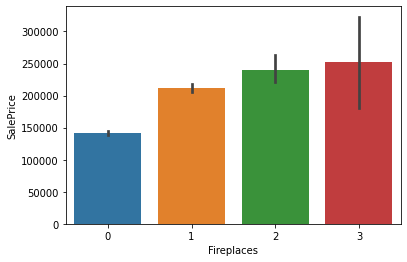

In [117]:
sns.barplot(data = train_data,x='Fireplaces',y='SalePrice')

### FireplaceQual

<AxesSubplot:xlabel='FireplaceQu', ylabel='SalePrice'>

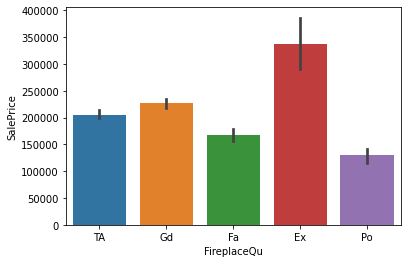

In [118]:
sns.barplot(data = train_data,x='FireplaceQu',y='SalePrice')

## Garage: has NAN

### GarageType

In [119]:
train_data['GarageType'] = train_data['GarageType'].fillna(0)

<AxesSubplot:xlabel='GarageType', ylabel='SalePrice'>

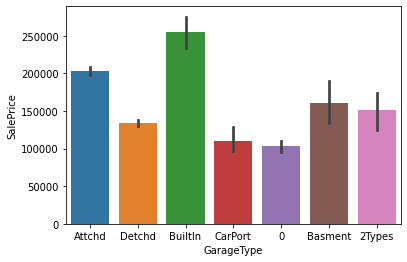

In [120]:
sns.barplot(data = train_data,x='GarageType',y='SalePrice')

### GarageYrBlt

In [121]:
train_data['GarageYrBlt'].isna().sum()

81

<AxesSubplot:xlabel='GarageYrBlt', ylabel='SalePrice'>

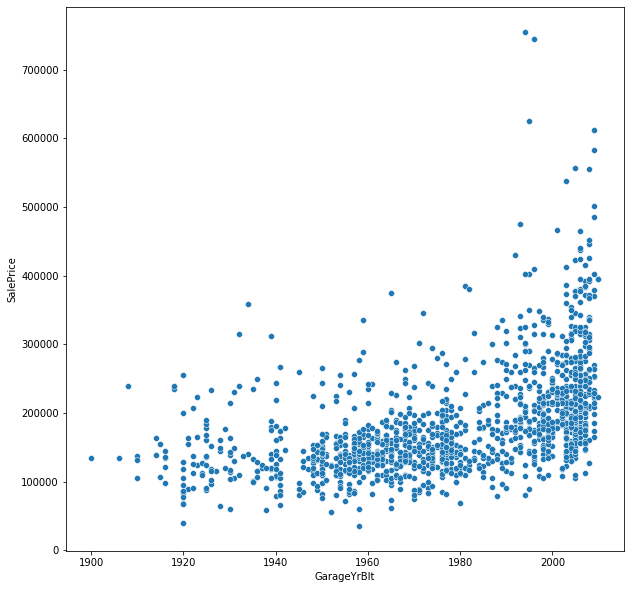

In [122]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='GarageYrBlt',y='SalePrice')

### GarageFinish

<AxesSubplot:xlabel='GarageFinish', ylabel='SalePrice'>

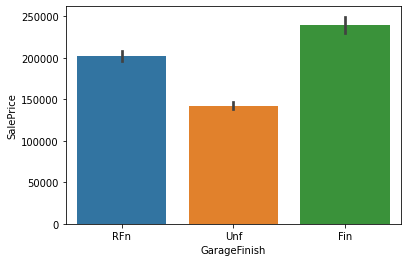

In [123]:
sns.barplot(data = train_data,x='GarageFinish',y='SalePrice')

### GarageCars

In [124]:
train_data['GarageCars'].value_counts()

2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

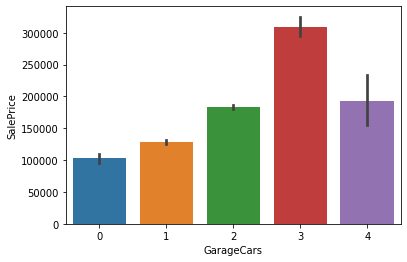

In [125]:
sns.barplot(data= train_data,x='GarageCars',y='SalePrice')

### GarageArea

<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

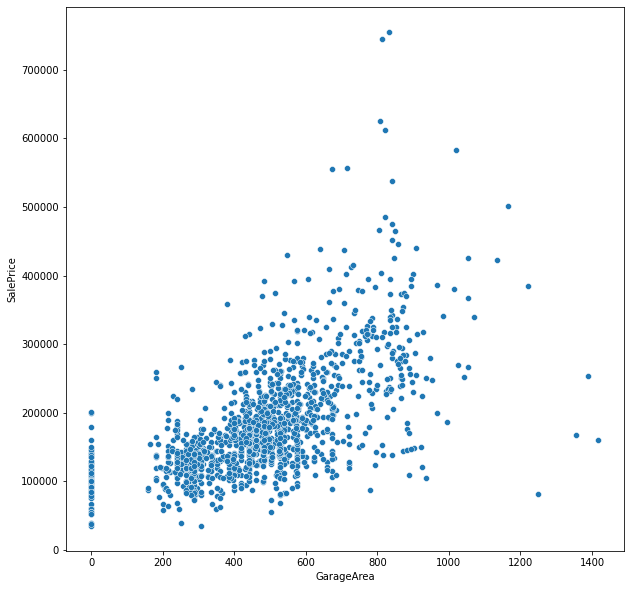

In [126]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='GarageArea',y='SalePrice')

In [127]:
train_data['GarageArea'] = train_data['GarageArea'].apply(lambda x: ScaleNotChangePrice('GarageArea',x) if x > 1230 else x)

<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

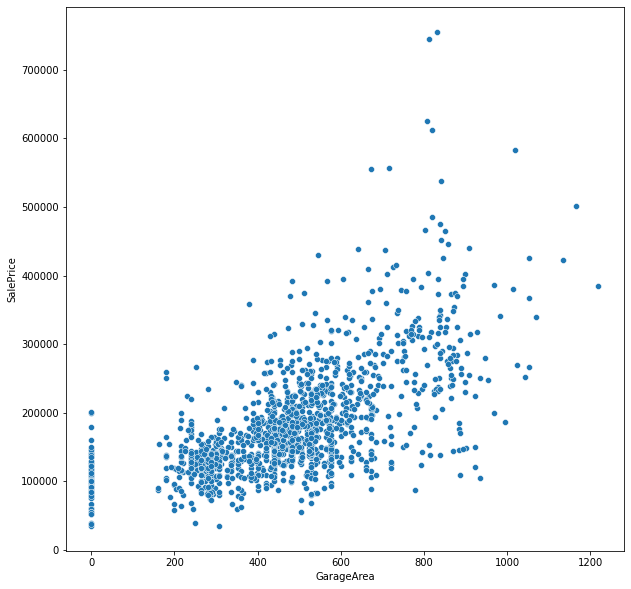

In [128]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='GarageArea',y='SalePrice')

### GarageQual

<AxesSubplot:xlabel='GarageQual', ylabel='SalePrice'>

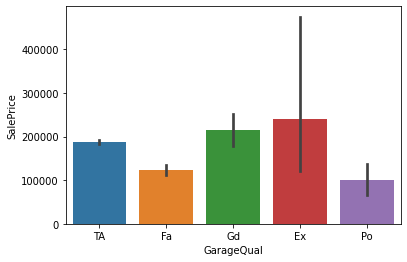

In [129]:
sns.barplot(data = train_data,x='GarageQual',y='SalePrice')

### GarageCond

<AxesSubplot:xlabel='GarageCond', ylabel='SalePrice'>

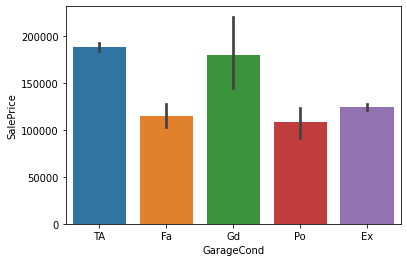

In [130]:
sns.barplot(data= train_data,x='GarageCond',y='SalePrice')

why Ex is lower?

## PavedDrive: Paved driveway

<AxesSubplot:xlabel='PavedDrive', ylabel='SalePrice'>

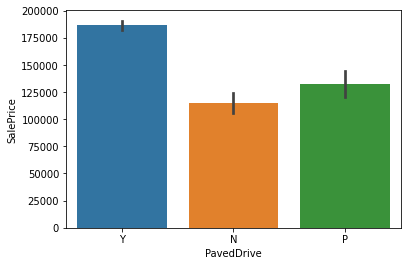

In [131]:
sns.barplot(data = train_data,x='PavedDrive',y='SalePrice')

## WoodDeckSF: a wooden floor built outside, where people can sit and relax


<AxesSubplot:xlabel='WoodDeckSF', ylabel='SalePrice'>

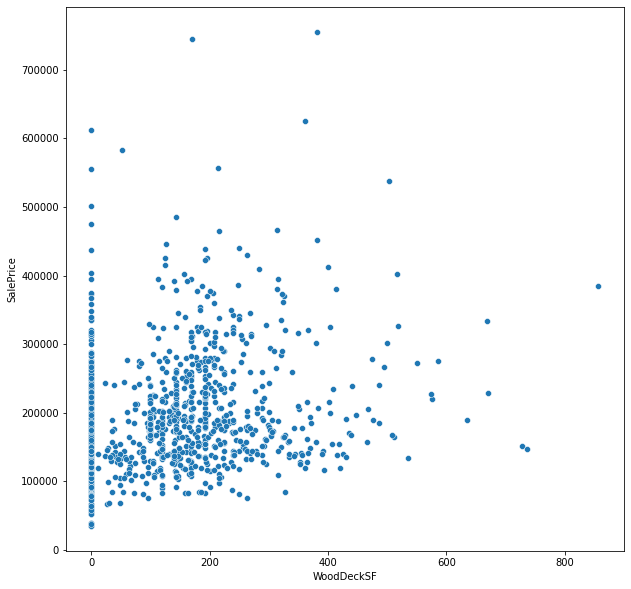

In [132]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = train_data,x='WoodDeckSF',y='SalePrice')

In [133]:
train_data['WoodDeckSF'] = train_data['WoodDeckSF'].apply(lambda x: ScaleNotChangePrice('WoodDeckSF',x) if x > 800 else x)

<AxesSubplot:xlabel='WoodDeckSF', ylabel='SalePrice'>

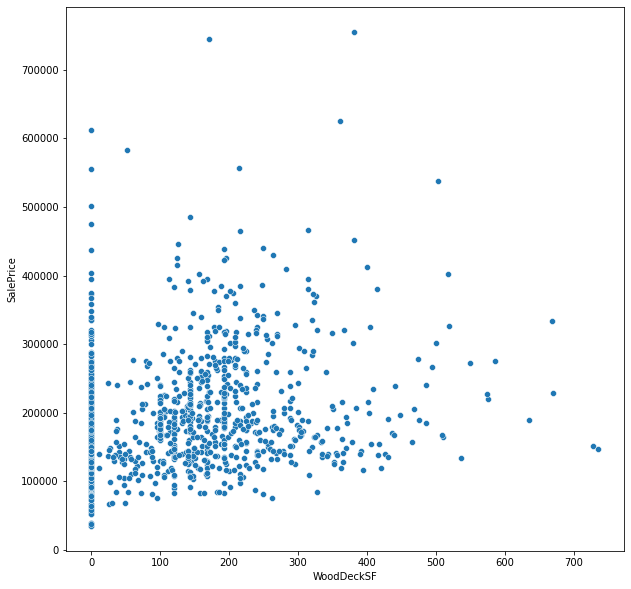

In [134]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = train_data,x='WoodDeckSF',y='SalePrice')

## OpenPorchSF: Open porch area in square feet

<AxesSubplot:xlabel='OpenPorchSF', ylabel='SalePrice'>

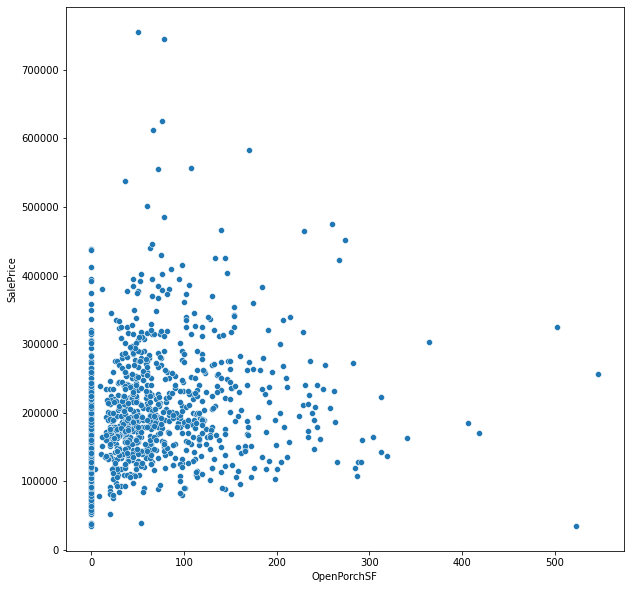

In [135]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='OpenPorchSF',y='SalePrice')

In [136]:
train_data['OpenPorchSF'] = train_data['OpenPorchSF'].apply(lambda x: ScaleNotChangePrice('OpenPorchSF',x) if x > 500 else x)

<AxesSubplot:xlabel='OpenPorchSF', ylabel='SalePrice'>

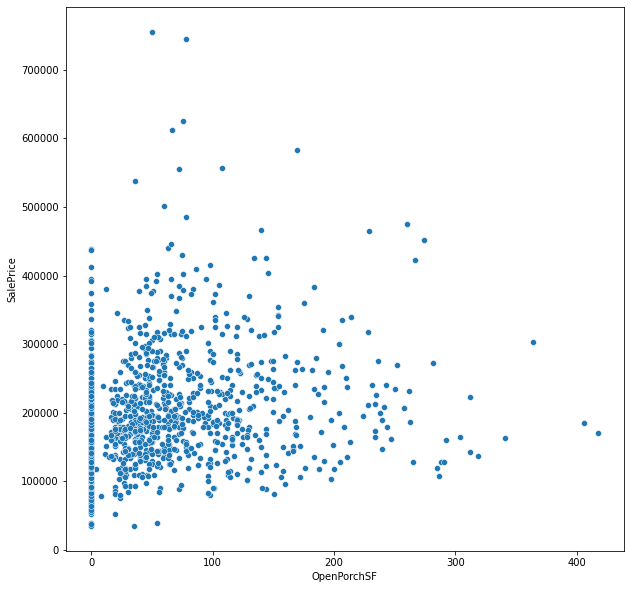

In [137]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='OpenPorchSF',y='SalePrice')

## EnclosedPorch: Enclosed porch area in square feet


<AxesSubplot:xlabel='EnclosedPorch', ylabel='SalePrice'>

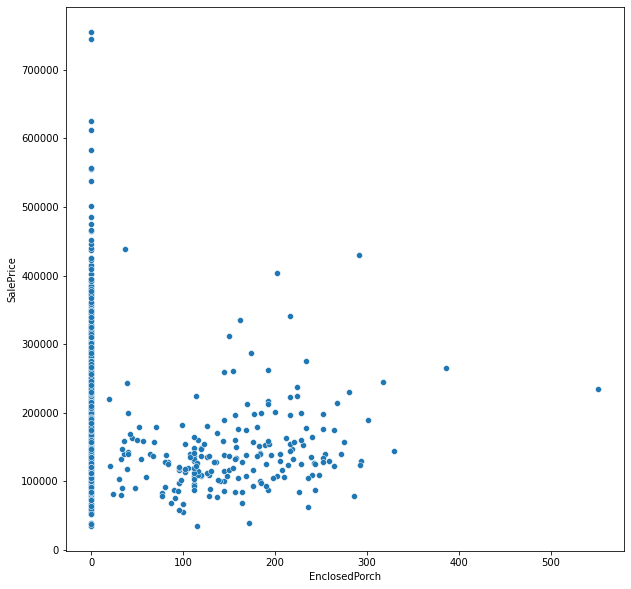

In [138]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='EnclosedPorch',y='SalePrice')

In [139]:
train_data['EnclosedPorch'] = train_data['EnclosedPorch'].apply(lambda x: ScaleNotChangePrice('EnclosedPorch',x) if x > 350 else x)

<AxesSubplot:xlabel='EnclosedPorch', ylabel='SalePrice'>

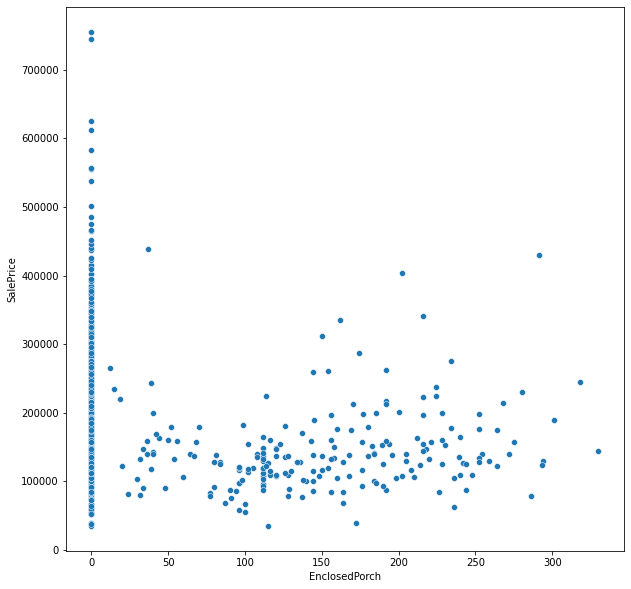

In [140]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='EnclosedPorch',y='SalePrice')

## 3SsnPorch: Three season porch area in square feet

<AxesSubplot:xlabel='3SsnPorch', ylabel='SalePrice'>

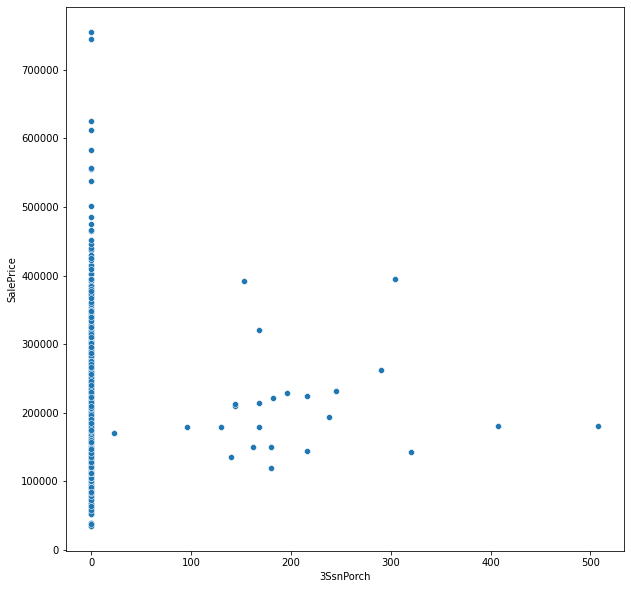

In [141]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='3SsnPorch',y='SalePrice')

In [142]:
train_data['3SsnPorch'] = train_data['3SsnPorch'].apply(lambda x: ScaleNotChangePrice('3SsnPorch',x) if x > 350 else x)

<AxesSubplot:xlabel='3SsnPorch', ylabel='SalePrice'>

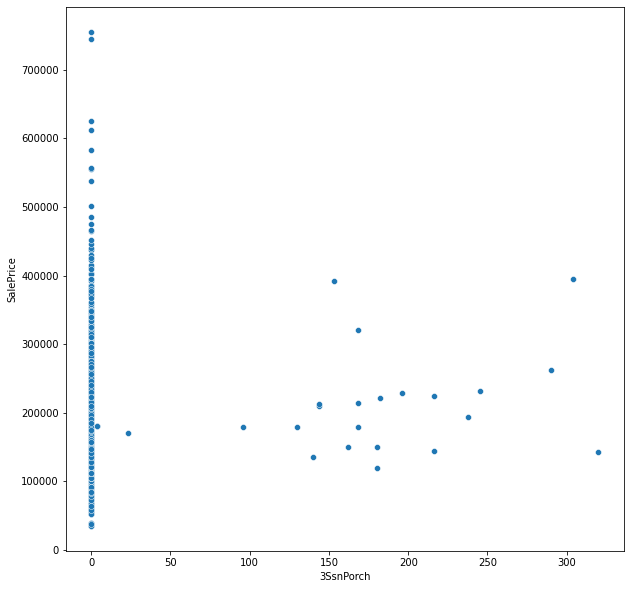

In [143]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='3SsnPorch',y='SalePrice')

## ScreenPorch: Screen porch area in square feet

<AxesSubplot:xlabel='ScreenPorch', ylabel='SalePrice'>

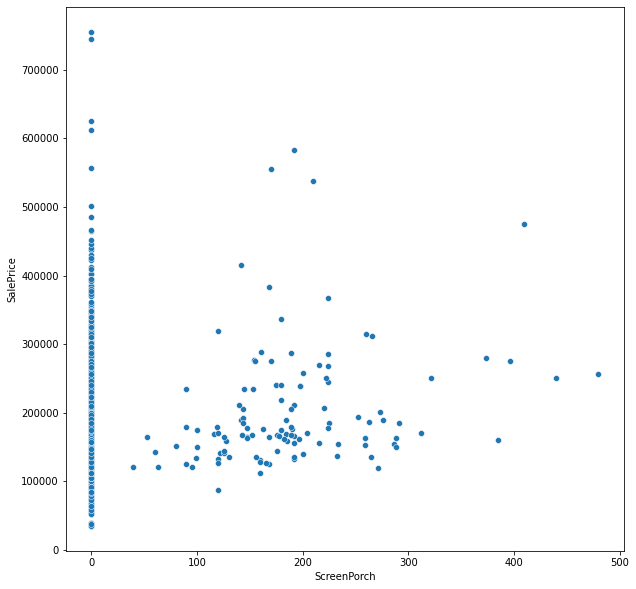

In [144]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=train_data,x='ScreenPorch',y='SalePrice')

## Pool

### PoolArea

<AxesSubplot:xlabel='PoolArea', ylabel='SalePrice'>

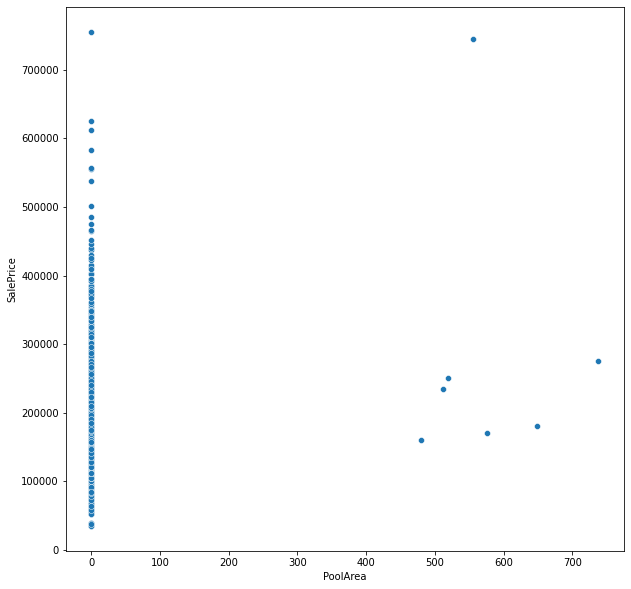

In [145]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = train_data,x='PoolArea',y='SalePrice')

### PoolQC

In [146]:
train_data['PoolQC'] = train_data['PoolQC'].fillna(0)

<AxesSubplot:xlabel='PoolQC', ylabel='SalePrice'>

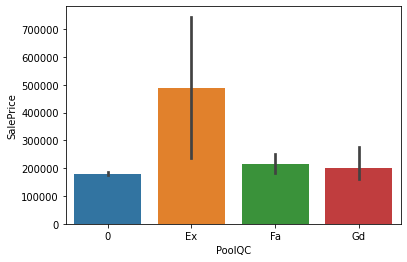

In [147]:
sns.barplot(data = train_data,x='PoolQC',y='SalePrice')

## Fence: Fence quality

In [148]:
train_data['Fence'] = train_data['Fence'].fillna(0)

<AxesSubplot:xlabel='Fence', ylabel='SalePrice'>

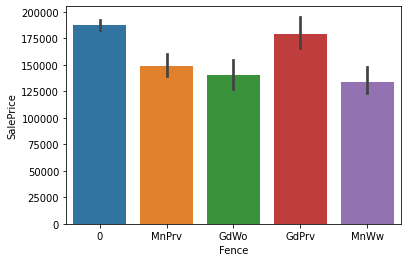

In [149]:
sns.barplot(data = train_data,x='Fence',y='SalePrice')

## Miscellaneous

### MiscFeature: Miscellaneous feature not covered in other categories

In [150]:
train_data['MiscFeature'] = train_data['MiscFeature'].fillna(0)

<AxesSubplot:xlabel='MiscFeature', ylabel='SalePrice'>

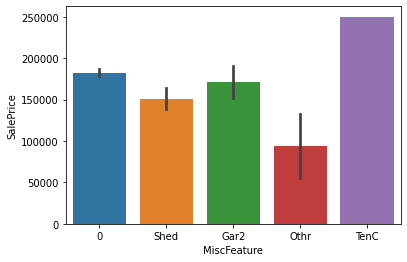

In [151]:
sns.barplot(data = train_data,x='MiscFeature',y='SalePrice')

### MiscVal

<AxesSubplot:xlabel='MiscVal', ylabel='SalePrice'>

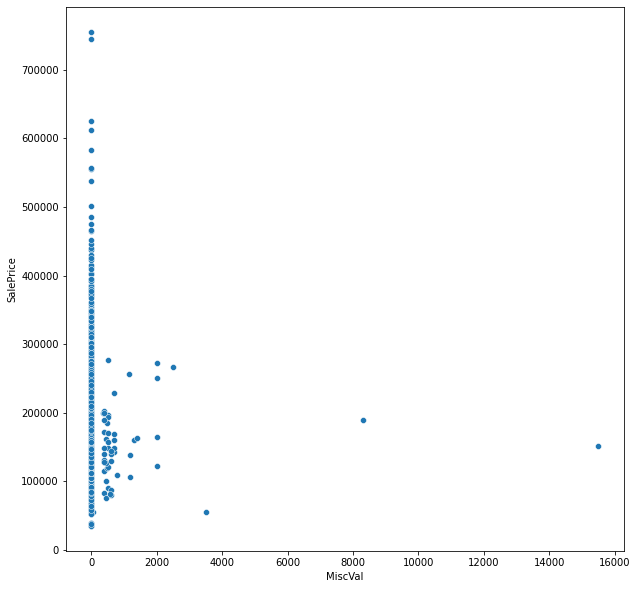

In [152]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='MiscVal',y='SalePrice')

In [153]:
train_data['MiscVal'] = train_data['MiscVal'].apply(lambda x: ScaleNotChangePrice('MiscVal',x) if x > 3000 else x)

<AxesSubplot:xlabel='MiscVal', ylabel='SalePrice'>

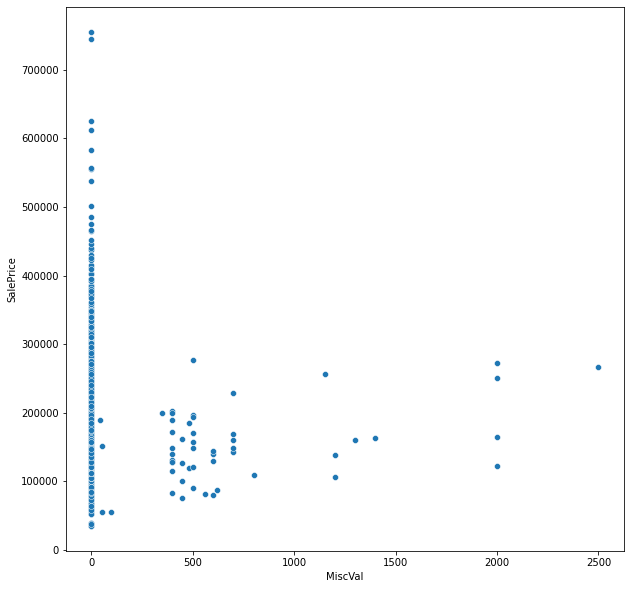

In [154]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='MiscVal',y='SalePrice')

## Time Sold

### MoSold: Month 

<AxesSubplot:xlabel='MoSold', ylabel='SalePrice'>

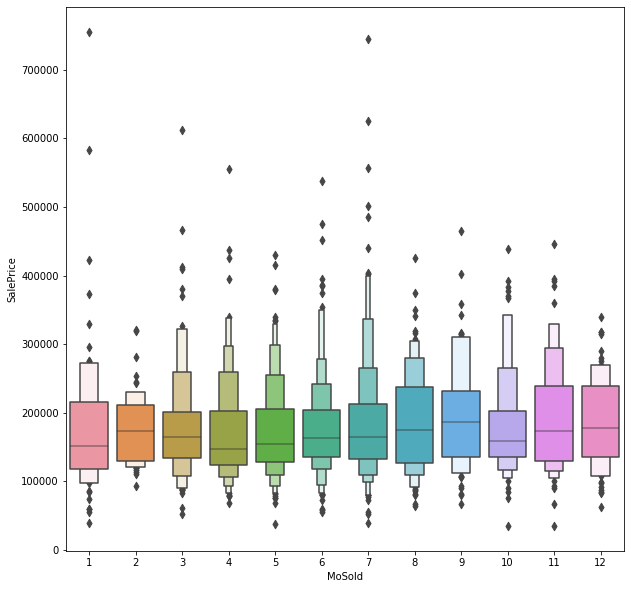

In [155]:
plt.figure(figsize=(10,10))
sns.boxenplot(data = train_data,x='MoSold',y='SalePrice')

### YrSold: Year Sold

<AxesSubplot:xlabel='YrSold', ylabel='SalePrice'>

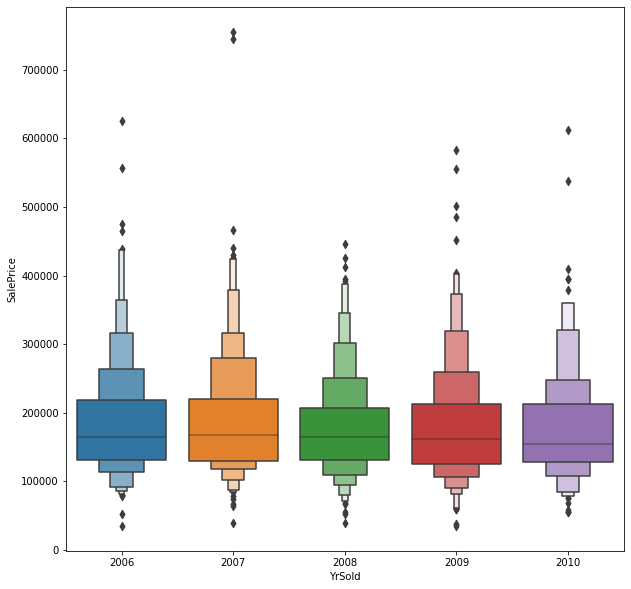

In [156]:
plt.figure(figsize=(10,10))
sns.boxenplot(data = train_data,x='YrSold',y='SalePrice')

## Sale

## SaleType

<AxesSubplot:xlabel='SaleType', ylabel='SalePrice'>

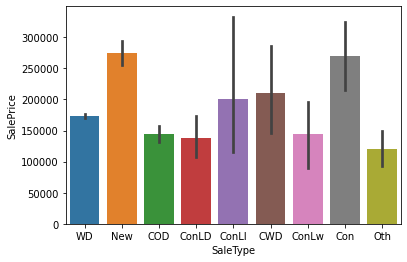

In [157]:
sns.barplot(data = train_data,x='SaleType',y='SalePrice')

## SaleCondition

<AxesSubplot:xlabel='SaleCondition', ylabel='SalePrice'>

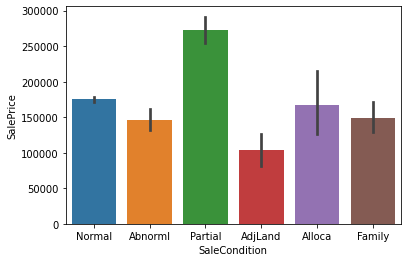

In [158]:
sns.barplot(data = train_data,x='SaleCondition',y='SalePrice')

## Correlation 

In [14]:
train_data.corr()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


In [15]:
_set = set()
for i in list(train_data.corr()):
    temp = dict(train_data.corr()[i])
    arr = []
    for key,value in temp.items():
        if (value >= 0.5 and value < 1):
            _set.add((i,key,value))

In [16]:
lst = []
for i in _set:
    lst.append(list(i))

In [17]:
index_first = 0
_len = len(lst)
while (index_first < _len):
    index_second = 0
    while (index_second < _len - 1 and index_first < _len):
        try :
            if lst[index_first][0] == lst[index_second][1] and lst[index_first][1] == lst[index_second][0]:
                lst.remove([lst[index_second][0],lst[index_second][1],lst[index_second][2]])
                index_second -= 1
                _len -= 1
        except IndexError:
            print(index_first,index_second)
        index_second += 1
    index_first += 1

In [18]:
lst.sort(key = lambda x:x[2],reverse=True)
lst

[['GarageCars', 'GarageArea', 0.882475414281462],
 ['YearBuilt', 'GarageYrBlt', 0.8256674841743408],
 ['GrLivArea', 'TotRmsAbvGrd', 0.8254893743088425],
 ['1stFlrSF', 'TotalBsmtSF', 0.8195299750050339],
 ['SalePrice', 'OverallQual', 0.7909816005838053],
 ['SalePrice', 'GrLivArea', 0.7086244776126515],
 ['GrLivArea', '2ndFlrSF', 0.6875010641666033],
 ['BedroomAbvGr', 'TotRmsAbvGrd', 0.676619935742649],
 ['BsmtFullBath', 'BsmtFinSF1', 0.6492117535742649],
 ['YearRemodAdd', 'GarageYrBlt', 0.6422767797035356],
 ['GarageCars', 'SalePrice', 0.6404091972583519],
 ['GrLivArea', 'FullBath', 0.6300116462511148],
 ['GarageArea', 'SalePrice', 0.6234314389183622],
 ['2ndFlrSF', 'TotRmsAbvGrd', 0.6164226354915431],
 ['SalePrice', 'TotalBsmtSF', 0.6135805515591943],
 ['HalfBath', '2ndFlrSF', 0.6097073002717436],
 ['SalePrice', '1stFlrSF', 0.6058521846919153],
 ['GarageCars', 'OverallQual', 0.6006707165907149],
 ['GrLivArea', 'OverallQual', 0.5930074300286512],
 ['YearBuilt', 'YearRemodAdd', 0.5928549